In [1]:
from graphstats import *
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import scale
from pandas import read_csv
from importlib import reload

In [14]:
import _pickle as pickle
data = pickle.load(open('LL1_net_nom_data.pkl', 'rb'))

In [15]:
G = data['0']
g = nx.to_numpy_array(G)
adj = [g]
MORE_ATTR = True
attr_number = 1
while MORE_ATTR:
    attr = 'attr'
    temp_attr = np.array(list(networkx.get_node_attributes(G, 'attr' + str(attr_number)).values()))
    if len(temp_attr) == 0:
        MORE_ATTR = False
    else:
        adj.append(temp_attr)
        attr_number += 1

In [16]:
attr1 = adj[1]
adj[1] = scale(attr1)
attr2 = adj[2]
adj[2] = scale(attr2)

In [17]:
vectors = np.zeros((len(G), len(adj[1:])))
for i in range(len(G)):
    for j in range(1, len(adj)):
        vectors[i][j - 1] = adj[j][i]

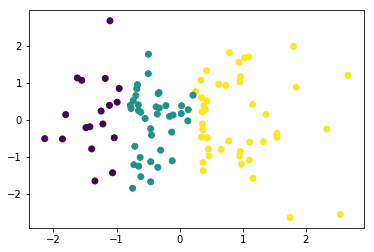

In [34]:
fig, ax = plt.subplots(1,1)
ax.scatter(vectors[:, 0], vectors[:, 1],c = truth)

In [18]:
D = np.zeros(shape = (len(G), len(G)))
for i in range(len(G)):
    for j in range(i + 1, len(G)):
        D[i, j] = np.linalg.norm(vectors[i] - vectors[j])
        D[j, i] = D[i, j]

In [19]:
csv = data['learningData']
training_idx = np.array(csv['G1.nodeID']).astype(int)
labels = np.array(csv['classLabel']).astype(int)

In [9]:
distance_lists = get_weights(D, training_idx, labels)

In [10]:
def plot_ecdf(array_or_list, extra = [], color = 'r'):
    array_or_list = np.array(array_or_list)
    
    if len(array_or_list[0]) == 0:
        return
    
    elif type(array_or_list[0]) == int:

        n = len(array_or_list)
        sorted_data = np.sort(array_or_list).copy()

        fig, ax = plt.subplots(1,1)
        ax.plot(sorted_data, np.arange(1, n + 1)/n, c = color, label = 'list1')
        if len(extra) > 0:
            extra_sorted = np.sort(extra).copy()
            ax.plot(extra_sorted, np.arange(1, len(extra) + 1)/len(extra), label = 'list2')
    elif type(array_or_list[0]) == list:
        d = len(array_or_list)
        fig, ax = plt.subplots(1,1)
        for i in range(d):
            temp_n = len(array_or_list[i])
            temp_sorted = np.sort(array_or_list[i])
            
            ax.plot(temp_sorted, np.arange(1, temp_n + 1)/temp_n, label = 'list%i'%(i+1))
        if len(extra) > 0:
            extra_sorted = np.sort(extra).copy()
            ax.plot(extra_sorted, np.arange(1, len(extra) + 1)/len(extra), label = 'list%i'%(i+2))
        ax.legend(loc = 'upper left')
    else:
        pass
    return

In [11]:
unlabeled = get_weights(D, training_idx, labels, index = 0)

(None, None, None)

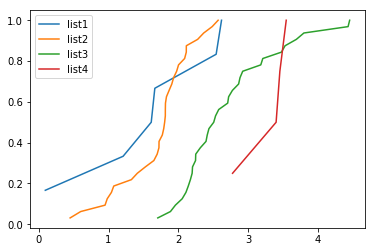

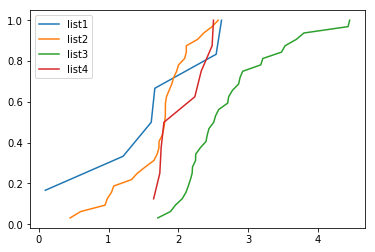

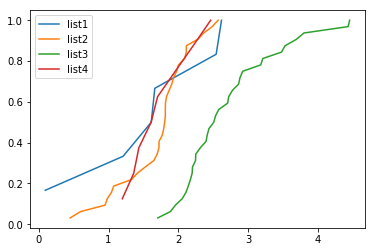

In [12]:
plot_ecdf(distance_lists[0], extra = unlabeled[0]), plot_ecdf(distance_lists[0], extra = unlabeled[1]), plot_ecdf(distance_lists[0], extra = unlabeled[2])

(None, None, None)

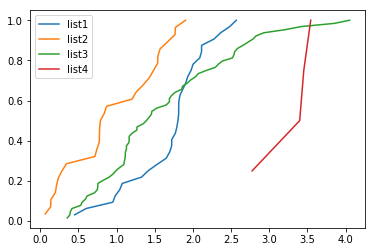

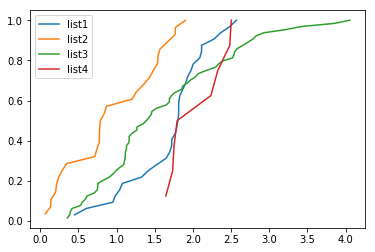

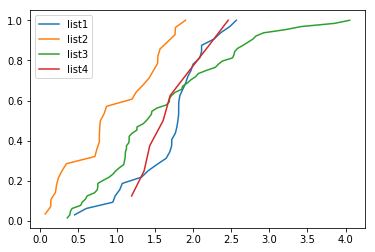

In [13]:
plot_ecdf(distance_lists[1], extra = unlabeled[0]), plot_ecdf(distance_lists[1], extra = unlabeled[1]), plot_ecdf(distance_lists[1], extra = unlabeled[2])

(None, None, None)

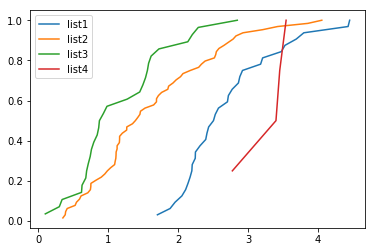

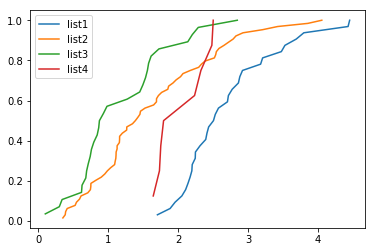

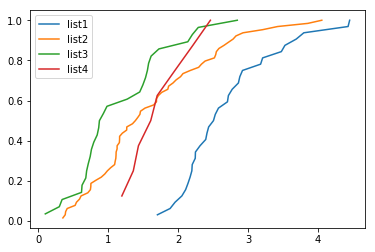

In [14]:
plot_ecdf(distance_lists[2], extra = unlabeled[0]), plot_ecdf(distance_lists[2], extra = unlabeled[1]), plot_ecdf(distance_lists[2], extra = unlabeled[2])

In [15]:
## 3 classification procedures
#1 - ASE
#2 - Omni
#3 - Update priors

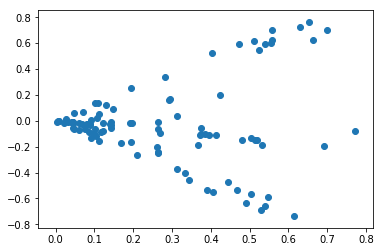

In [20]:
# 1 - ASE
X_hat = adj_spectral_embedding(g, max_dim=3)[0]
ase_labels = gaussian_classification(X_hat, training_idx, labels)
fig, ax = plt.subplots(1,1)
ax.scatter(X_hat[:, 0], X_hat[:, 1])

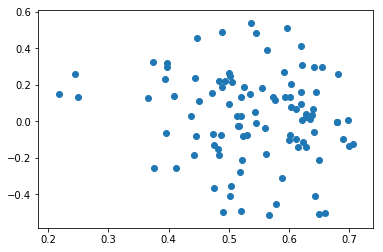

In [21]:
# 2 - Omni
exp_D = np.exp(-D**2 / 10)
hollow = exp_D - np.eye(exp_D.shape[0])
omni_ = omni_matrix([g, hollow], max_dim = 3)
omni_labels = gaussian_classification(omni_, training_idx, labels)

fig, ax = plt.subplots(1,1)
ax.scatter(omni_[:, 0], omni_[:, 1])

In [22]:
# 3 - Update priors
up_labels = updated_priors_classification(X_hat, D, training_idx, labels, method = 'kNN')

In [23]:
csv_truth = read_csv('learningData.csv')
truth = np.array(csv_truth['classLabel'])

In [44]:
just_attrs = gaussian_classification(vectors, training_idx, labels)

In [25]:
np.sum(truth == ase_labels), np.sum(truth == omni_labels), np.sum(truth == up_labels)#, np.sum(truth == just_attrs)

(77, 83, 81)

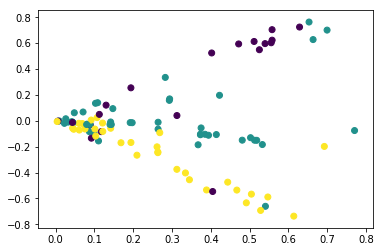

In [39]:
fig, ax = plt.subplots(1,1)
ax.scatter(X_hat[:, 0], X_hat[:, 1], c = up_labels)

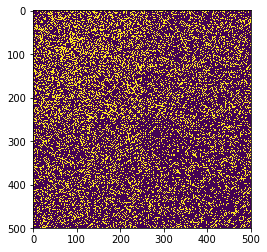

In [6]:
## Now, an attempt on synthetic data
n = 500
pi = [0.5, 0.5]
seed_ratio = 0.1

p = 0.55
q = 0.45

B = np.array([
    [p**2, p*q],
    [p*q, q**2],
])

A = adj_matrix(n, pi, B, acorn = 1)
plt.imshow(A)

In [7]:
all_labels = np.concatenate((np.zeros(int(n/2)), np.ones(int(n/2))))
training_idx1 = np.arange(0, int(seed_ratio*n/2))
training_idx2 = np.arange(int(n/2), int(n/2 + seed_ratio*n/2))
training_idx = np.concatenate((training_idx1, training_idx2))
training_labels = all_labels[training_idx]

np.random.seed(1)
attr1 = np.concatenate((np.random.normal(-1, 1, int(n/2)), np.random.normal(1, 1, int(n/2))))

In [8]:
D = np.zeros(shape = (n, n))
for i in range(n):
    for j in range(i + 1, n):
        D[i, j] = np.linalg.norm(attr1[i] - attr1[j])
        D[j, i] = D[i, j]

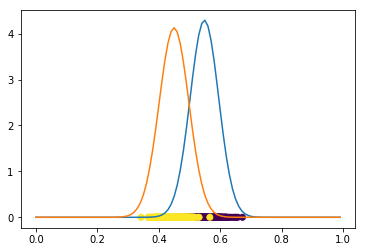

In [9]:
from scipy.stats import norm
X_hat_ = adj_spectral_embedding(A, max_dim = 1)[0]

mu1 = np.mean(X_hat_[training_idx1])
mu2 = np.mean(X_hat_[training_idx2])
s1 = np.std(X_hat_[training_idx1], ddof = 1)
s2 = np.std(X_hat_[training_idx2], ddof = 1)

fig, ax = plt.subplots(1,1)
ax.scatter(X_hat_, np.zeros(X_hat_.shape[0]), c = all_labels)
xs = np.arange(0,1,step=0.01)
ax.plot(xs, 0.5*norm.pdf(xs, mu1, s1))
ax.plot(xs, 0.5*norm.pdf(xs, mu2, s2))

In [10]:
preds = gaussian_classification(X_hat_, training_idx, training_labels)

In [11]:
preds2 = updated_priors_classification(X_hat_, D, training_idx, training_labels, method = "kNN")

In [12]:
kNN_preds = kNN(D, training_idx, training_labels, 5).astype(float)
kNN_preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 1.

In [13]:
np.sum(preds == all_labels), np.sum(preds2 == all_labels), np.sum(kNN_preds == all_labels)

(464, 468, 421)

In [10]:
len(kNN_preds), len(all_labels)

(450, 500)

In [ ]:
# What happends if we, instead of comparing the the ecdf of the distances, which makes little sensse,
# we use the similarity metric that comes out of K-NN to update priors -- 
# 1) K-NN is univerally consistent and so we know that it is unlikely that we "hurt" our classification
# accuracy (esp. asymptotically; it is important to understand when/if updating priors using a K-NN like procedure
# degrades performance)


# Perhaps two sets of cross-validation
# 1) Optimize estimated Gaussians
# 2) Once Gaussians optimal k in {0, 1, .., K} where K <= N